In [1]:
import numpy as np
import rasterio
from rasterio.plot import show
from skimage import exposure
import matplotlib.pyplot as plt

# Load images
s1_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S1_VV_2023_07_04.tif"
s2_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S2_RGBNIR_2023-07-01.tif"

with rasterio.open(s1_path) as src1:
    s1 = src1.read(1).astype(np.float32)
    profile = src1.profile

with rasterio.open(s2_path) as src2:
    s2 = src2.read().astype(np.float32)  # shape: (4, H, W) for R,G,B,NIR

# Normalize
s1 = (s1 - s1.min()) / (s1.max() - s1.min())
s2 = (s2 - s2.min()) / (s2.max() - s2.min())


In [3]:
import rasterio
from rasterio.enums import Resampling

def resample_to_match(reference_path, source_path):
    with rasterio.open(reference_path) as ref:
        ref_shape = (ref.height, ref.width)
        ref_transform = ref.transform
        ref_crs = ref.crs

    with rasterio.open(source_path) as src:
        data = src.read(
            out_shape=(1, ref_shape[0], ref_shape[1]),
            resampling=Resampling.bilinear
        )
        data = data[0]  # drop extra dimension
        return data.astype(np.float32)

s1_resampled = resample_to_match(s2_path, s1_path)

# Normalize
s1_norm = (s1_resampled - s1_resampled.min()) / (s1_resampled.max() - s1_resampled.min())
s2_norm = (s2 - s2.min()) / (s2.max() - s2.min())


In [4]:
def ihs_fusion(s1, s2):
    r, g, b = s2[0], s2[1], s2[2]
    i = (r + g + b) / 3
    h = np.arctan2(np.sqrt(3) * (g - b), 2 * r - g - b + 1e-6)
    s = np.sqrt((r - g)**2 + (r - b)*(g - b))

    i_new = s1
    r_new = i_new + 2/3 * s * np.cos(h)
    g_new = i_new - 1/3 * s * (np.cos(h) - np.sqrt(3)*np.sin(h))
    b_new = i_new - 1/3 * s * (np.cos(h) + np.sqrt(3)*np.sin(h))

    return np.clip(np.stack([r_new, g_new, b_new]), 0, 1)

ihs_result = ihs_fusion(s1_norm, s2_norm)


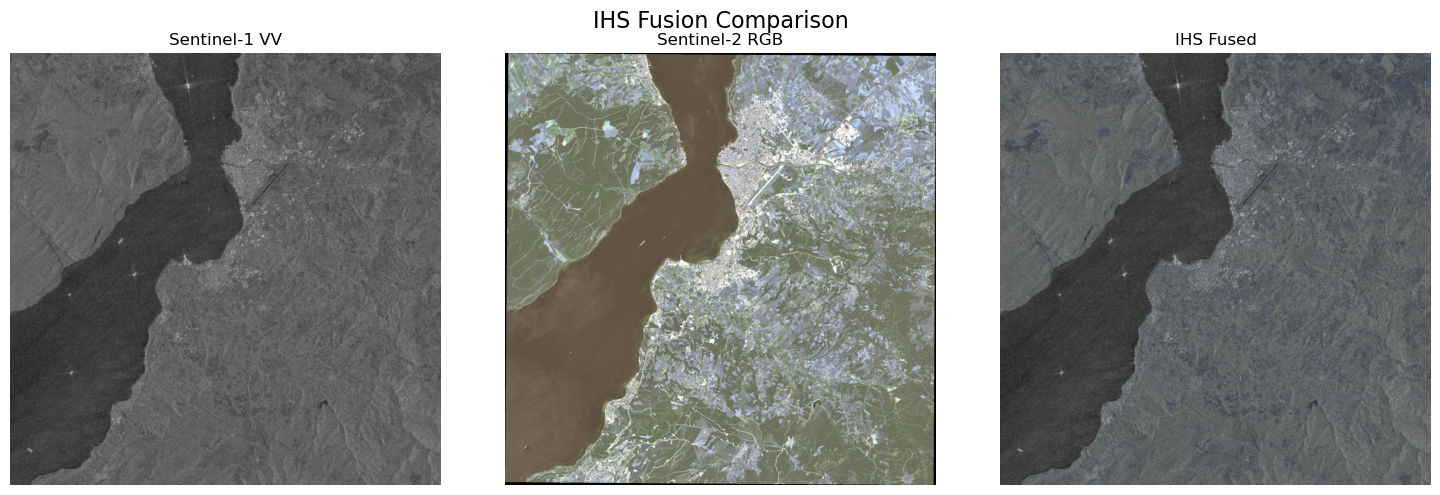

In [18]:
import numpy as np
import matplotlib.pyplot as plt

def linear_stretch(img, low=0, high=99):
    """Apply linear contrast stretch per channel using percentiles."""
    stretched = np.zeros_like(img)
    for i in range(img.shape[0]):
        p_low, p_high = np.percentile(img[i], (low, high))
        stretched[i] = np.clip((img[i] - p_low) / (p_high - p_low + 1e-6), 0, 1)
    return stretched

def show_comparison(s1, s2, fused, title="IHS Fusion Comparison"):
    plt.figure(figsize=(15, 5))

    # Sentinel-1 grayscale
    plt.subplot(1, 3, 1)
    plt.imshow(s1, cmap='gray')
    plt.title("Sentinel-1 VV")
    plt.axis('off')

    # Sentinel-2 RGB with linear stretch
    s2_stretched = linear_stretch(s2[:3])
    plt.subplot(1, 3, 2)
    plt.imshow(np.moveaxis(s2_stretched, 0, -1))
    plt.title("Sentinel-2 RGB")
    plt.axis('off')

    # IHS fused
    plt.subplot(1, 3, 3)
    plt.imshow(np.moveaxis(fused, 0, -1))
    plt.title("IHS Fused")
    plt.axis('off')

    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()
show_comparison(s1_norm, s2_norm, ihs_result)


In [19]:
import rasterio

def save_fused_image(output_path, fused_array, reference_path):
    """
    Save a fused RGB image using the spatial metadata from a reference image (e.g., Sentinel-2).
    """
    fused_array = np.clip(fused_array * 255, 0, 255).astype(np.uint8)  # convert to 8-bit

    with rasterio.open(reference_path) as ref:
        profile = ref.profile
        profile.update({
            'count': 3,
            'dtype': 'uint8',
            'compress': 'lzw'
        })

        with rasterio.open(output_path, 'w', **profile) as dst:
            dst.write(fused_array[0], 1)
            dst.write(fused_array[1], 2)
            dst.write(fused_array[2], 3)

# Example usage
output_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\ihs_fused.tif"
save_fused_image(output_path, ihs_result, s2_path)


BROVEY

In [20]:
def brovey_transform(s1, s2):
    r, g, b = s2[0], s2[1], s2[2]
    denom = r + g + b + 1e-6  # avoid division by zero
    fused = np.stack([
        (r / denom) * s1,
        (g / denom) * s1,
        (b / denom) * s1
    ])
    return np.clip(fused, 0, 1)

brovey_result = brovey_transform(s1_norm, s2_norm)


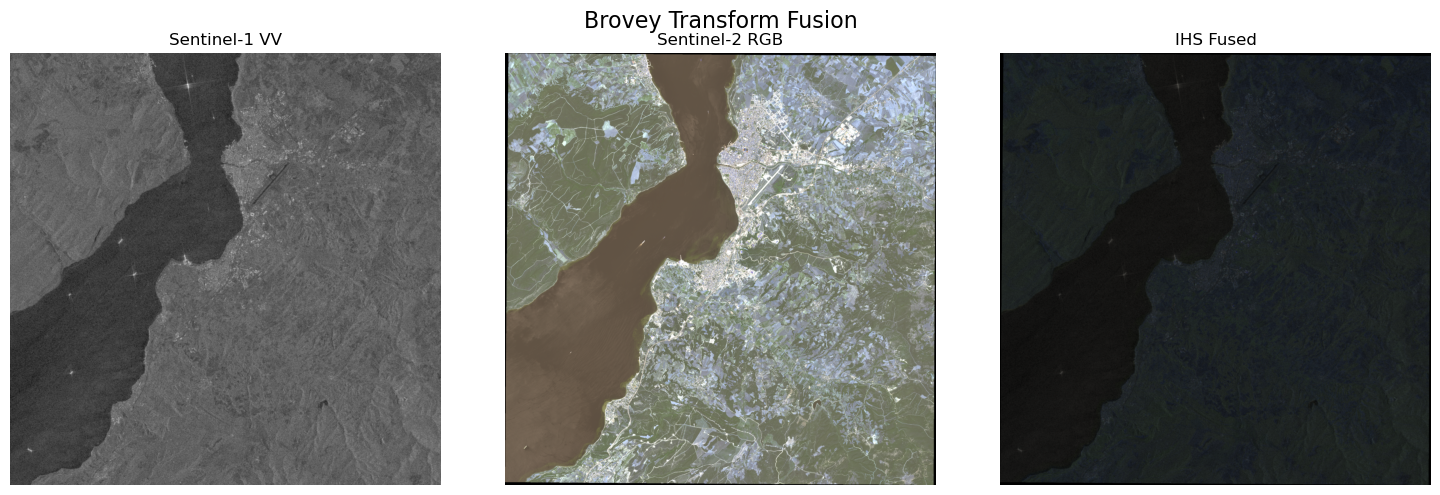

In [21]:
show_comparison(s1_norm, s2_norm, brovey_result, title="Brovey Transform Fusion")


In [22]:
save_fused_image(r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\brovey_fused.tif",
                 brovey_result, s2_path)


PCA

In [23]:
from sklearn.decomposition import PCA

def pca_fusion(s1, s2):
    H, W = s1.shape
    rgb = s2[:3].reshape(3, -1).T  # (H*W, 3)
    
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(rgb)
    
    pcs[:, 0] = s1.flatten()  # replace PC1 with SAR
    inv = pca.inverse_transform(pcs).T.reshape(3, H, W)
    return np.clip(inv, 0, 1)

pca_result = pca_fusion(s1_norm, s2_norm)


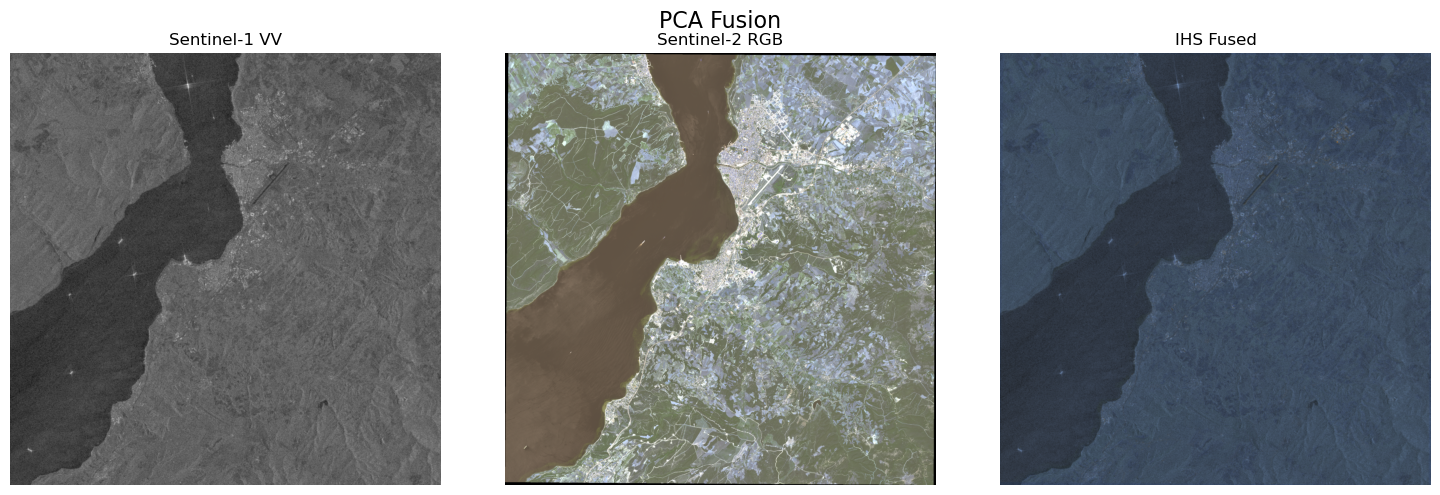

In [24]:
show_comparison(s1_norm, s2_norm, pca_result, title="PCA Fusion")


In [25]:
save_fused_image(r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\pca_fused.tif",
                 pca_result, s2_path)


fsdfk

In [26]:
from skimage.metrics import structural_similarity as ssim
from scipy.stats import pearsonr

def compute_metrics(fused, reference):
    """
    fused: (3, H, W), reference: (3, H, W)
    """
    rmse_list, ssim_list, cc_list = [], [], []
    for i in range(3):  # R, G, B
        ref_band = reference[i].flatten()
        fused_band = fused[i].flatten()

        rmse = np.sqrt(np.mean((fused_band - ref_band) ** 2))
        ssim_val = ssim(reference[i], fused[i], data_range=1.0)
        cc, _ = pearsonr(fused_band, ref_band)

        rmse_list.append(rmse)
        ssim_list.append(ssim_val)
        cc_list.append(cc)

    return {
        'RMSE': np.mean(rmse_list),
        'SSIM': np.mean(ssim_list),
        'CC': np.mean(cc_list)
    }


In [28]:
import pandas as pd

# Stretch reference S2 RGB for better comparison (2–98 percentile)
s2_rgb_stretched = linear_stretch(s2_norm[:3])

# Compute metrics
ihs_metrics = compute_metrics(ihs_result, s2_rgb_stretched)
brovey_metrics = compute_metrics(brovey_result, s2_rgb_stretched)
pca_metrics = compute_metrics(pca_result, s2_rgb_stretched)

# Assemble table
df_metrics = pd.DataFrame({
    "RMSE": [ihs_metrics['RMSE'], brovey_metrics['RMSE'], pca_metrics['RMSE']],
    "SSIM": [ihs_metrics['SSIM'], brovey_metrics['SSIM'], pca_metrics['SSIM']],
    "Correlation": [ihs_metrics['CC'], brovey_metrics['CC'], pca_metrics['CC']]
}, index=["IHS", "Brovey", "PCA"])

# Print rounded table
print("\n=== Quantitative Evaluation of Fusion Methods ===")
print(df_metrics.round(4))



=== Quantitative Evaluation of Fusion Methods ===
          RMSE    SSIM  Correlation
IHS     0.2118  0.2879       0.3955
Brovey  0.4133  0.2218       0.5212
PCA     0.2648  0.3529       0.4073


In [29]:
# Sentinel-1 normalize edilmiş hali zaten s1_norm olarak tanımlı

def compute_metrics_against_s1(fused_rgb, s1_ref):
    """
    fused_rgb: (3, H, W), s1_ref: (H, W)
    Compute similarity between each RGB channel and the SAR image.
    Then average the scores.
    """
    rmse_list, ssim_list, cc_list = [], [], []
    for i in range(3):  # RGB kanalları
        band = fused_rgb[i]
        rmse = np.sqrt(np.mean((band - s1_ref) ** 2))
        ssim_val = ssim(s1_ref, band, data_range=1.0)
        cc, _ = pearsonr(band.flatten(), s1_ref.flatten())

        rmse_list.append(rmse)
        ssim_list.append(ssim_val)
        cc_list.append(cc)

    return {
        'RMSE': np.mean(rmse_list),
        'SSIM': np.mean(ssim_list),
        'CC': np.mean(cc_list)
    }

# Hesapla
ihs_s1_metrics = compute_metrics_against_s1(ihs_result, s1_norm)
brovey_s1_metrics = compute_metrics_against_s1(brovey_result, s1_norm)
pca_s1_metrics = compute_metrics_against_s1(pca_result, s1_norm)

# Tabloyu yazdır
import pandas as pd

df_s1_metrics = pd.DataFrame({
    "RMSE": [ihs_s1_metrics['RMSE'], brovey_s1_metrics['RMSE'], pca_s1_metrics['RMSE']],
    "SSIM": [ihs_s1_metrics['SSIM'], brovey_s1_metrics['SSIM'], pca_s1_metrics['SSIM']],
    "Correlation": [ihs_s1_metrics['CC'], brovey_s1_metrics['CC'], pca_s1_metrics['CC']]
}, index=["IHS", "Brovey", "PCA"])

print("\n=== S1 (SAR) ile Benzerlik Değerlendirmesi ===")
print(df_s1_metrics.round(4))



=== S1 (SAR) ile Benzerlik Değerlendirmesi ===
          RMSE    SSIM  Correlation
IHS     0.0106  0.9947       0.9947
Brovey  0.2429  0.4714       0.8374
PCA     0.0763  0.8793       0.9914


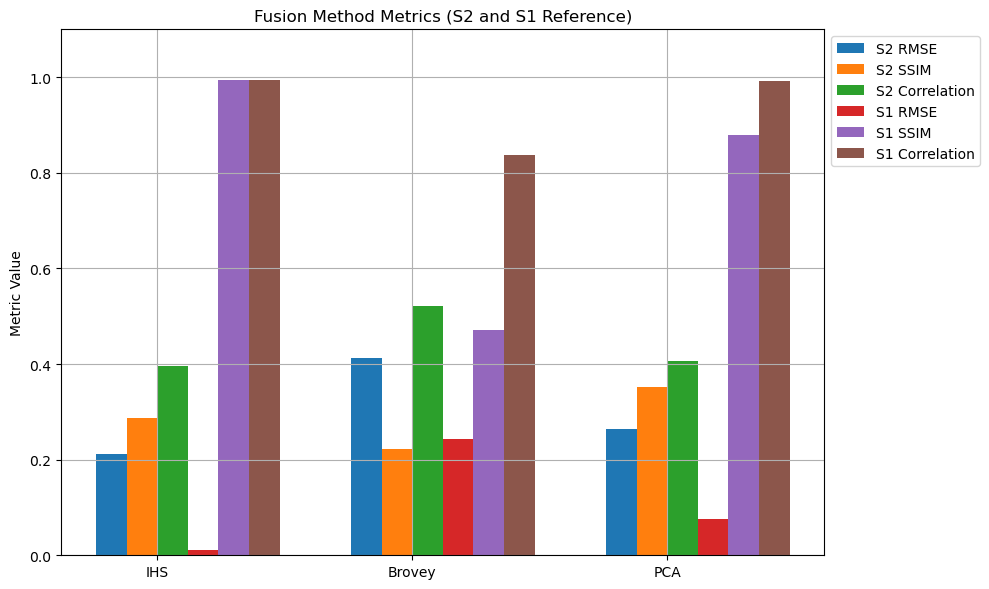

In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Fusion methods
methods = ['IHS', 'Brovey', 'PCA']
x = np.arange(len(methods))
width = 0.12  # bar width

# Metrics for S2 and S1
s2_rmse = [0.2118, 0.4133, 0.2648]
s2_ssim = [0.2879, 0.2218, 0.3529]
s2_corr = [0.3955, 0.5212, 0.4073]

s1_rmse = [0.0106, 0.2429, 0.0763]
s1_ssim = [0.9947, 0.4714, 0.8793]
s1_corr = [0.9947, 0.8374, 0.9914]

# Plot all metrics in one figure
fig, ax = plt.subplots(figsize=(10, 6))

# Grouped bars: [S2_RMSE, S2_SSIM, S2_CC, S1_RMSE, S1_SSIM, S1_CC]
ax.bar(x - 1.5 * width, s2_rmse, width, label='S2 RMSE')
ax.bar(x - 0.5 * width, s2_ssim, width, label='S2 SSIM')
ax.bar(x + 0.5 * width, s2_corr, width, label='S2 Correlation')

ax.bar(x + 1.5 * width, s1_rmse, width, label='S1 RMSE')
ax.bar(x + 2.5 * width, s1_ssim, width, label='S1 SSIM')
ax.bar(x + 3.5 * width, s1_corr, width, label='S1 Correlation')

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylabel("Metric Value")
ax.set_ylim(0, 1.1)
ax.set_title("Fusion Method Metrics (S2 and S1 Reference)")
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.grid(True)

plt.tight_layout()
plt.show()


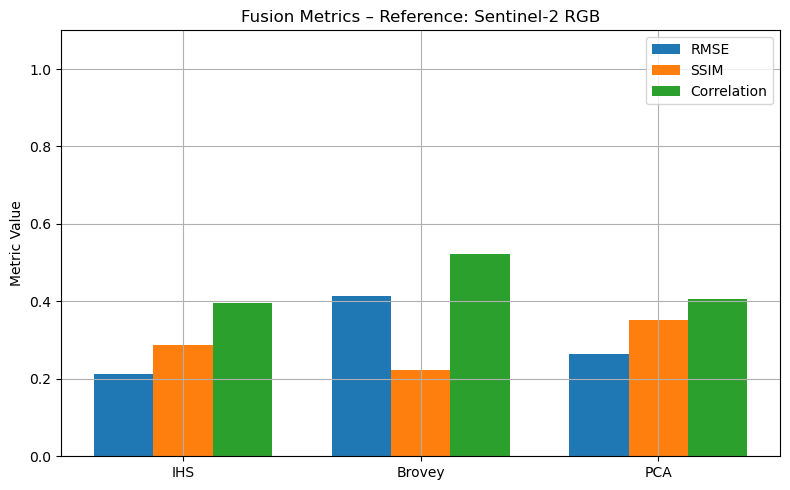

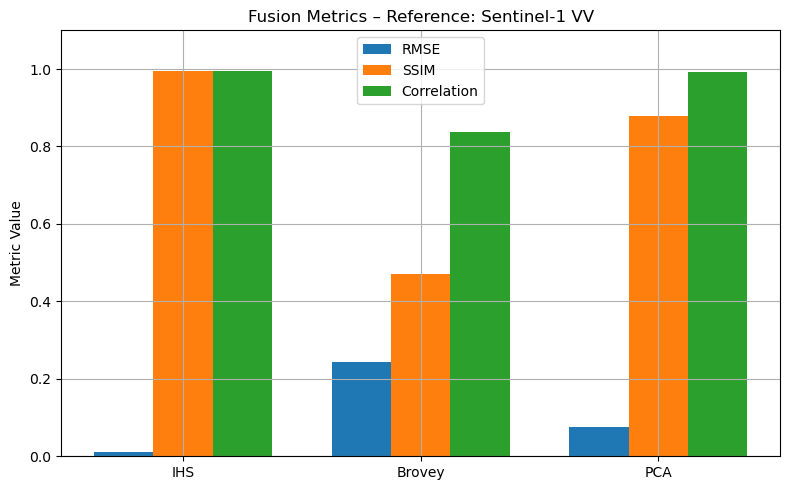

In [34]:
import matplotlib.pyplot as plt
import numpy as np

# Yöntemler
methods = ['IHS', 'Brovey', 'PCA']
x = np.arange(len(methods))
width = 0.25

# Sentinel-2 referanslı metrikler
s2_rmse = [0.2118, 0.4133, 0.2648]
s2_ssim = [0.2879, 0.2218, 0.3529]
s2_corr = [0.3955, 0.5212, 0.4073]

# Sentinel-1 referanslı metrikler
s1_rmse = [0.0106, 0.2429, 0.0763]
s1_ssim = [0.9947, 0.4714, 0.8793]
s1_corr = [0.9947, 0.8374, 0.9914]

# === Grafik 1: Sentinel-2 Referanslı ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, s2_rmse, width, label='RMSE')
ax.bar(x, s2_ssim, width, label='SSIM')
ax.bar(x + width, s2_corr, width, label='Correlation')

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Metric Value")
ax.set_title("Fusion Metrics – Reference: Sentinel-2 RGB")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()

# === Grafik 2: Sentinel-1 Referanslı ===
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width, s1_rmse, width, label='RMSE')
ax.bar(x, s1_ssim, width, label='SSIM')
ax.bar(x + width, s1_corr, width, label='Correlation')

ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.set_ylim(0, 1.1)
ax.set_ylabel("Metric Value")
ax.set_title("Fusion Metrics – Reference: Sentinel-1 VV")
ax.legend()
ax.grid(True)

plt.tight_layout()
plt.show()


In [38]:
def stretch(img, low=2, high=98):
    """Apply percentile-based linear contrast stretch to 3-band image."""
    out = np.zeros_like(img)
    for i in range(3):
        p_low, p_high = np.percentile(img[i], (low, high))
        out[i] = np.clip((img[i] - p_low) / (p_high - p_low + 1e-6), 0, 1)
    return out

# Apply stretching to each fusion result
ihs_stretched = stretch(ihs_result)
brovey_stretched = stretch(brovey_result)
pca_stretched = stretch(pca_result)


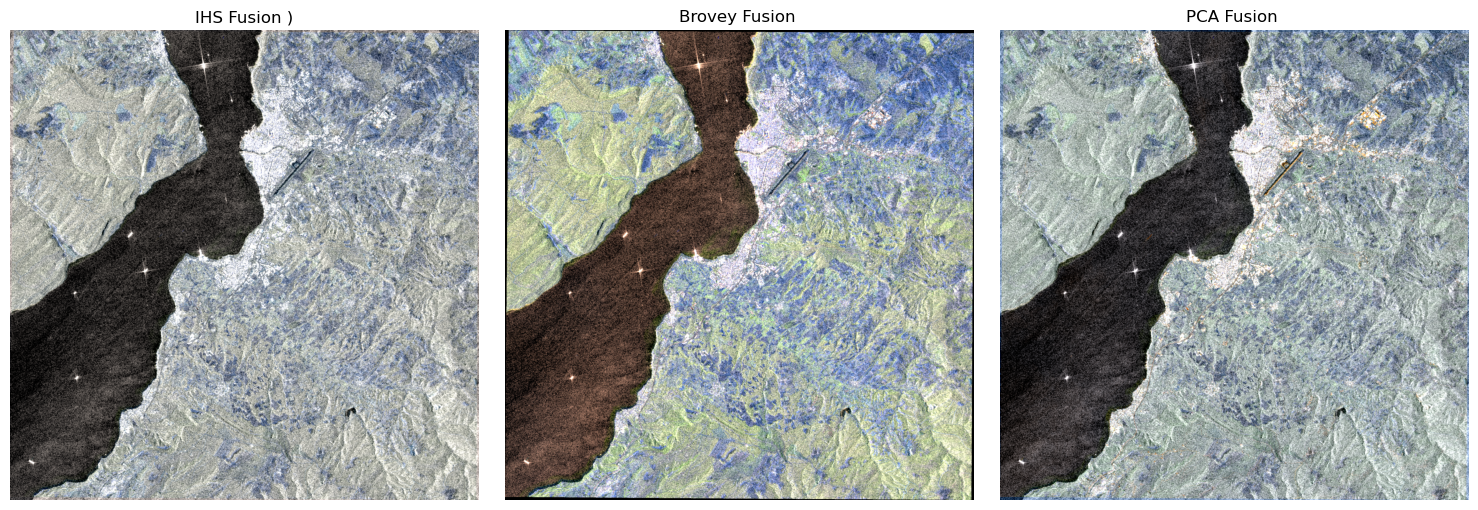

In [40]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.imshow(np.moveaxis(ihs_stretched, 0, -1))
plt.title("IHS Fusion )")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(np.moveaxis(brovey_stretched, 0, -1))
plt.title("Brovey Fusion ")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(np.moveaxis(pca_stretched, 0, -1))
plt.title("PCA Fusion ")
plt.axis('off')

plt.tight_layout()
plt.show()


In [46]:
import rasterio
import numpy as np

# Paths
s1_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S1_VV_2023_07_04.tif"
s2_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S2_RGBNIR_2023-07-01.tif"

# Load Sentinel-1
with rasterio.open(s1_path) as src1:
    s1 = src1.read(1).astype(np.float32)
    s1_norm = (s1 - s1.min()) / (s1.max() - s1.min())

# Load Sentinel-2
with rasterio.open(s2_path) as src2:
    s2 = src2.read().astype(np.float32)  # shape: (4, H, W)
    s2_norm = (s2 - s2.min()) / (s2.max() - s2.min())


In [47]:
import rasterio
import numpy as np

s1_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S1_VV_2023_07_04.tif"
s2_path = r"C:\Users\Zeynep\Desktop\ZK\8.dönem\advenceRS\proje\S2_RGBNIR_2023-07-01.tif"

# Load Sentinel-1 VV
with rasterio.open(s1_path) as src1:
    s1 = src1.read(1).astype(np.float32)
    s1_norm = (s1 - s1.min()) / (s1.max() - s1.min())

# Load Sentinel-2 (RGB + NIR)
with rasterio.open(s2_path) as src2:
    s2 = src2.read().astype(np.float32)  # shape: (4, H, W)
    s2_norm = (s2 - s2.min()) / (s2.max() - s2.min())


In [51]:
from skimage.transform import resize

# Resize Sentinel-1 to match Sentinel-2 shape
target_shape = s2_norm.shape[1:]  # (H, W)
s1_resized = resize(s1_norm, target_shape, order=1, mode='reflect', preserve_range=True, anti_aliasing=True)


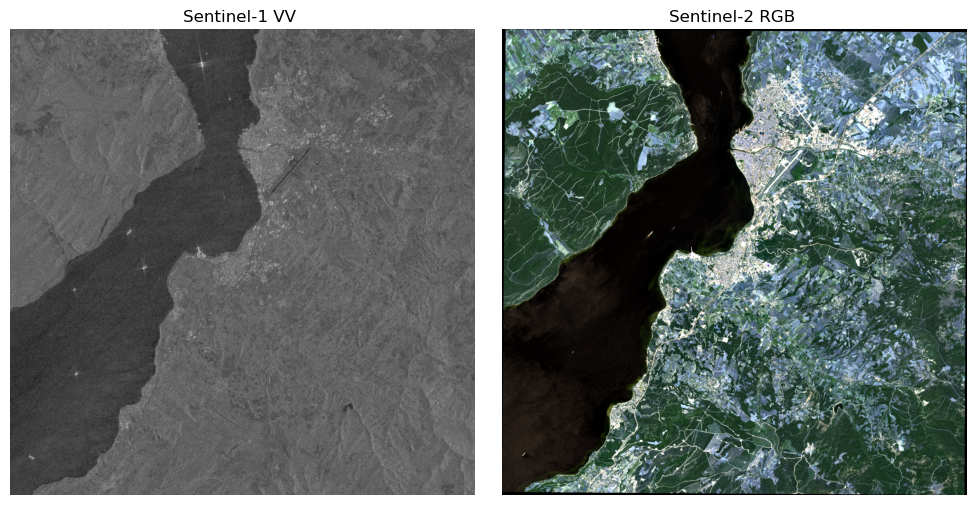

In [53]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(s1_resized, cmap='gray')
plt.title("Sentinel-1 VV ")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(np.moveaxis(s2_rgb_stretched, 0, -1))
plt.title("Sentinel-2 RGB ")
plt.axis('off')

plt.tight_layout()
plt.show()
